# Interpretability and Algorithmic Fairness Project 

The goal of this project is to apply the techniques described in class to a 
the setting of a credit-worthiness prediciton.  

### Group members:
- Nicolas Barbier de la Serre
- Juien Bernardo
- Henrique Brito Leao
- Benjamin Derre
- Hippolyte Guigon 

## Imports

In [51]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from scipy.stats import chi2_contingency, chi2

from xgboost import XGBRegressor, XGBClassifier

import matplotlib.pyplot as plt

from fpdp import fpdp_isolate

## Import data

In [2]:
# import data
data = pd.read_excel('../data/data_project.xlsx')

# set globals
CATEGORICAL_COLS = ['CreditHistory', 'EmploymentDuration', 'Housing', 
                    'Purpose', 'Savings']
BINARY_COLS = ['Group', 'Gender']
TARGET_COLS = ['y_hat', 'CreditRisk (y)']
NUMERICAL_COLS = data.loc[:, ~data.columns.isin(CATEGORICAL_COLS+TARGET_COLS+BINARY_COLS)].columns.tolist()

## Step 1: Surrogate models

*Use the estimated probability to be classified as good type (no default) provided in the 
dataset (y_hat). Implement one or two surrogate method(s) to interpret the unknown model used to 
generate y_hat.*

## Step 2: Model estimation

*Estimate your own black‐box machine learning model forecasting the  
probability to be classified as good type. For the train and test datasets, use a 70‐30 partition.*

In [3]:
# select full data 
data_full = data.copy()
train_data = data_full.loc[data_full.y_hat.isna()]
test_data = data_full.loc[data_full.y_hat.notnull()]

y_train = train_data['CreditRisk (y)'].to_numpy()
y_test = test_data['CreditRisk (y)'].to_numpy()
X_train = train_data.drop(['CreditRisk (y)', 'y_hat'], axis=1)
X_test = test_data.drop(['CreditRisk (y)', 'y_hat'], axis=1)
X_full = data_full.drop(['CreditRisk (y)', 'y_hat'], axis=1)

transformer = make_column_transformer(
    (OneHotEncoder(), CATEGORICAL_COLS),
    remainder='passthrough'
)

X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.fit_transform(X_test)
X_full_prep = transformer.fit_transform(X_full)

clf = XGBClassifier()
clf.fit(X_train_prep, y_train)

[00:14:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Step 3: Model performance

*Analyze the performance of your own model.*

# Global interpretability

## Step 4: Surrogate models

*Implement one or two surrogate method(s) to interpret your own 
model. Compare the results provided in Steps 1 and 4.*

## Step 5: PDP

*Implement the PDP method to interpret your own model.*

## Step 6: ALE

*Implement the ALE method to interpret your own model. Compare 
the results provided in Steps 5 and 6.*

# Local Interpretability

## Step 7: ICE

*Implement the ICE method to interpret your own model.*

## Step 8: SHAP

*Implement the SHAP method to interpret your own model. Compare 
the results provided in Steps 7 and 8.*

# Fairness

## Step 9: Fairness assessment

*Use a Pearson statistic for the following three fairness 
definitions: Statistical Parity, Conditional Statistical Parity (groups are given in the dataset), and Equal 
Odds. Discuss your results.*

Here we analyze whether the model discriminates between men and women when making predicitons.

In [4]:
# recover predicitons and true values

y_pred = clf.predict(X_full_prep)
y_true = data_full.loc[:, 'CreditRisk (y)']

In [6]:
def display_fairness_results(test_statistic: float, p_val:float, message=None) -> None:
    print(f'The chi-squared statistic is: {test_statistic:.2f}')
    print(f'The test p-value is: {p_val:.2e}')

    if p_val < 0.05:
        os.system('say "Your model is mysoginistic"')
    else:
        os.system('say "Your model is progressive"')

### Statistical Parity

In [7]:
def compute_vanilla_chi_squared(
    preds: np.ndarray, 
    fairness_column: pd.Series
) -> tuple[float, float]:
    contingency_table = pd.crosstab(preds, fairness_column)
    test_statistic, p_val, _, _ = chi2_contingency(contingency_table)
    
    return test_statistic, p_val

In [8]:
test_statistic, p_val = compute_vanilla_chi_squared(y_pred, data_full['Gender'])
display_fairness_results(test_statistic, p_val)

The chi-squared statistic is: 8.52
The test p-value is: 3.51e-03


### Conditional Statistical Parity

Here we consider the groups provided in the dataset to make a fairness evaluation.
The groups contain information on whether an individual is credit-worthy or not. 

In [13]:
def compute_conditional_chi_squared(
    groups: list[int], 
    group_column: pd.Series, 
    preds: np.ndarray, 
    fairness_column: pd.Series,
) -> tuple[float, float]:
    # initialize test_statistic result
    test_statistic = 0
    
    for group in groups:
        # select indexes of corresponding group
        group_idx = np.where(group_column==group)[0]
        group_preds = preds[group_idx]
        
        contingency_table = pd.crosstab(group_preds, 
                                        fairness_column[group_idx])
        chi_sq_stats, _, _, _ = chi2_contingency(contingency_table)
        test_statistic += chi_sq_stats
    
    # calculate the p-value
    p_val = chi2.pdf(test_statistic, 2)
    
    return test_statistic, p_val

In [14]:
test_statistic, p_val = compute_conditional_chi_squared(
    [0, 1], 
    data_full['Group'],
    y_pred, 
    data_full['Gender']
)

display_fairness_results(test_statistic, p_val)

The chi-squared statistic is: 11.78
The test p-value is: 1.38e-03


### Equal odds

Here we test the fairness of the model given the true outcome.

In [15]:
type(data_full['Gender'])

pandas.core.series.Series

In [16]:
test_statistic, p_val = compute_conditional_chi_squared(
    [0, 1], 
    y_true,
    y_pred, 
    pd.Series(data_full['Gender'])
)

display_fairness_results(test_statistic, p_val)

The chi-squared statistic is: 0.62
The test p-value is: 3.67e-01


## Step 10: FPDF

*Implement a FPDP using a fairness measure. Discuss your results.*

In [17]:
ONE_HOT_COLS = transformer.transformers_[0][1].get_feature_names(CATEGORICAL_COLS).tolist()

dataset = pd.DataFrame(data=X_full_prep, columns=NUMERICAL_COLS+ONE_HOT_COLS+BINARY_COLS)

dataset.columns = ONE_HOT_COLS+NUMERICAL_COLS+BINARY_COLS
dataset = dataset.dropna()

model_features = ONE_HOT_COLS+NUMERICAL_COLS+BINARY_COLS

In [72]:
ONE_HOT_COLS

['CreditHistory_A30',
 'CreditHistory_A31',
 'CreditHistory_A32',
 'CreditHistory_A33',
 'CreditHistory_A34',
 'EmploymentDuration_A71',
 'EmploymentDuration_A72',
 'EmploymentDuration_A73',
 'EmploymentDuration_A74',
 'EmploymentDuration_A75',
 'Housing_A151',
 'Housing_A152',
 'Housing_A153',
 'Purpose_A40',
 'Purpose_A41',
 'Purpose_A410',
 'Purpose_A42',
 'Purpose_A43',
 'Purpose_A44',
 'Purpose_A45',
 'Purpose_A46',
 'Purpose_A48',
 'Purpose_A49',
 'Savings_A61',
 'Savings_A62',
 'Savings_A63',
 'Savings_A64',
 'Savings_A65']

In [93]:
np.where(clf.predict_proba(X_full_prep)[:, 1] < 0.5) 

(array([   1,    4,    9,   10,   11,   13,   15,   18,   29,   35,   37,
          44,   54,   59,   62,   63,   67,   68,   74,   76,   80,   87,
          89,   92,   95,  101,  105,  106,  113,  116,  118,  124,  127,
         129,  131,  137,  141,  143,  148,  155,  166,  169,  170,  172,
         174,  175,  180,  181,  186,  188,  190,  191,  192,  194,  195,
         197,  203,  213,  218,  226,  227,  228,  230,  235,  236,  240,
         242,  244,  249,  252,  257,  268,  273,  274,  278,  291,  295,
         298,  301,  302,  304,  308,  309,  313,  315,  320,  321,  332,
         333,  334,  335,  337,  342,  349,  350,  351,  355,  357,  359,
         364,  368,  374,  375,  378,  381,  382,  394,  398,  402,  405,
         409,  412,  414,  416,  419,  424,  431,  433,  435,  443,  444,
         446,  449,  454,  457,  466,  470,  471,  472,  474,  475,  481,
         491,  496,  500,  503,  504,  505,  507,  510,  517,  521,  522,
         528,  531,  538,  540,  542, 

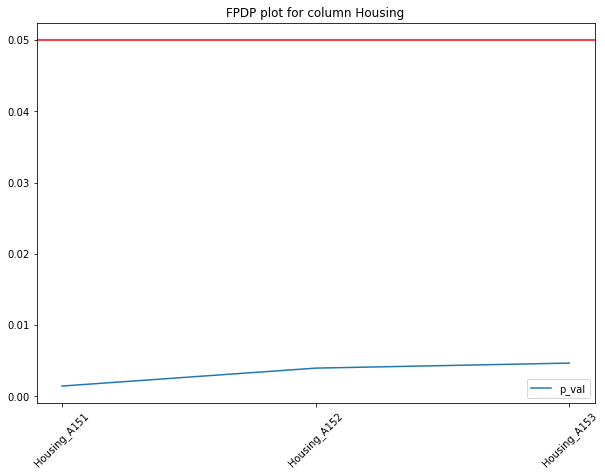

In [89]:
def get_fpdp_results(model, dataset:pd.DataFrame, model_features:list, column:str, group_column=None):
    cols = [feature for feature in dataset.columns if feature.split("_")[0]==column]

    if len(cols) == 1:
        feature = column
    else:
        feature = cols
    pdp_fare = fpdp_isolate(
        model=model,
        dataset=dataset,
        model_features=model_features,
        feature=feature
    )
    
    results = pd.DataFrame(columns=['p_val'])
    
    for col in pdp_fare.columns:
        preds = pdp_fare[col].apply(lambda x: 0 if x<0.5 else 1)
        
        if group_column is not None:
            results.loc[col, 'p_val'] =  compute_conditional_chi_squared(
                groups=[0, 1],
                group_column=group_column,
                preds=preds,
                fairness_column=dataset['Gender']
            )[1]
        else:
            results.loc[col, 'p_val'] =  compute_vanilla_chi_squared(
                preds=preds,
                fairness_column=dataset['Gender']
            )[1]
            
    fig, ax = plt.subplots(figsize=(10, 7))   
    fig = results.plot(title=f'FPDP plot for column {column}', ax=ax)
    plt.xticks(range(len(cols)), rotation=45)
    ax.set_xticklabels(cols)
    ax.axhline(y=0.05, color='r', linestyle='-')
    
    return fig

test = get_fpdp_results(clf, dataset, model_features, "Housing", group_column=dataset['Group'])


['Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49']
['Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49']
['Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49']


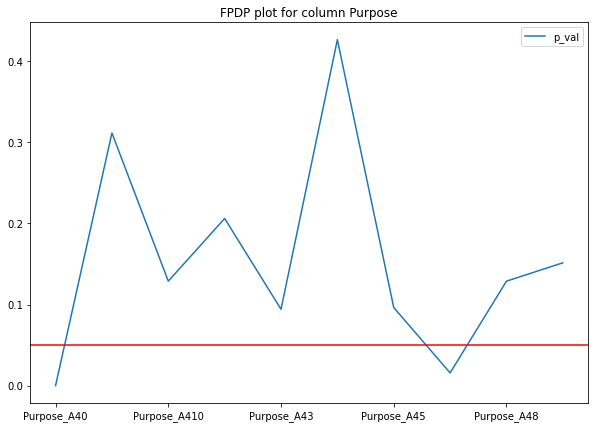

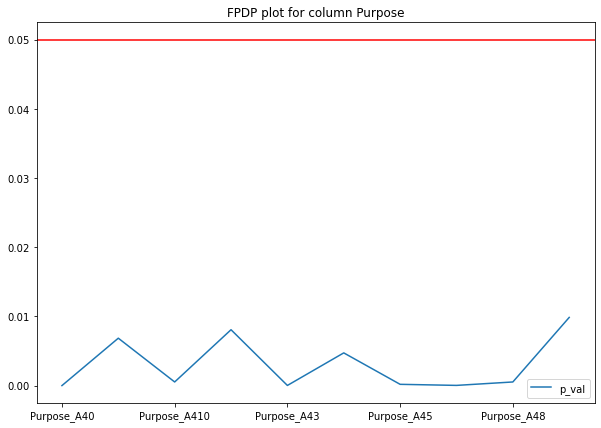

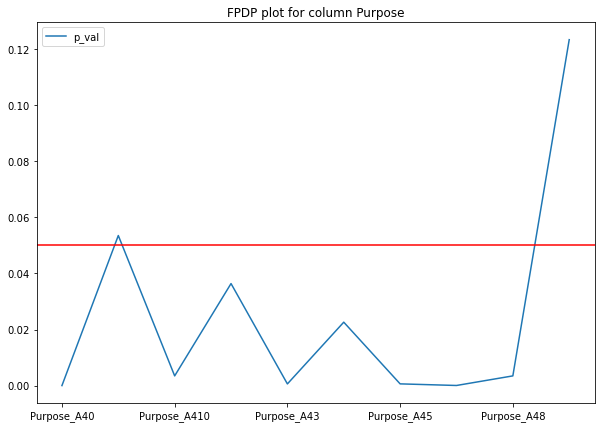

In [71]:
test_1 = get_fpdp_results(clf, dataset, model_features, "Purpose", group_column=y_true)
test_2 = get_fpdp_results(clf, dataset, model_features, "Purpose", group_column=dataset['Group'])
test_3 = get_fpdp_results(clf, dataset, model_features, "Purpose")